In [138]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.stattools import acf

from statsmodels.graphics.tsaplots import plot_acf

**Abordagens para Previsão**

- Forecast with Normal Dist. Random Values.
- Forecast with Naive;
- Forecast with Seasonal Naive;
- Forecast with Mean / Median;
- Forecast with Drift;
- Forecast with Decomposition;
- Forecast with Transformations;

**Metricas Para Avaliar as Previsões**

### 1.0. Simple Forecast Methods

#### 1.1. Bricks Production

In [2]:
df = pd.read_csv('../data/aus_production.csv', index_col=[0])

df_bricks = df[['Quarter', 'Bricks']].dropna()

df_bricks['Quarter'] = pd.PeriodIndex(df_bricks['Quarter'].str.replace(' ', '-'), freq='Q')

df_bricks['quarter_date'] = pd.to_datetime(df_bricks.Quarter.apply(lambda x: f'{x.year}-{x.month}-01'))

df_bricks.head()

,Quarter,Bricks,quarter_date
1,1956Q1,189.0,1956-03-01
2,1956Q2,204.0,1956-06-01
3,1956Q3,208.0,1956-09-01
4,1956Q4,197.0,1956-12-01
5,1957Q1,187.0,1957-03-01


In [3]:
forecast_horizon = 4

In [4]:
# Mean Method

yhat_mean = [df_bricks['Bricks'].mean()] * (2 * forecast_horizon)

In [5]:
# Naive Method

last_observation = df_bricks.sort_values(by='Quarter').tail(1)['Bricks'].values
yhat_naive = last_observation.tolist() * (2 * forecast_horizon)

In [6]:
# Seasonal Naive Method

# Missing two quarters of 2005.
df_bricks.sort_values(by='Quarter').tail(6)

,Quarter,Bricks,quarter_date
193,2004Q1,409.0,2004-03-01
194,2004Q2,423.0,2004-06-01
195,2004Q3,428.0,2004-09-01
196,2004Q4,397.0,2004-12-01
197,2005Q1,355.0,2005-03-01
198,2005Q2,435.0,2005-06-01


In [7]:
last_seasonal_observations = df_bricks.sort_values(by='Quarter').iloc[:-2, :].tail(4)['Bricks'].values
yhat_seasonal_nave = last_seasonal_observations.tolist() * int(forecast_horizon / 2)

In [8]:
dates = pd.date_range(
    start=df_bricks.quarter_date.max(),
    end=df_bricks.quarter_date.max() + pd.offsets.DateOffset(years=forecast_horizon),
    freq='Q-DEC'
)

dates = dates[(dates.year > 2005) & (dates.year < 2008)]

forecast = pd.DataFrame(
    {'quarter_date': dates,
     'mean': yhat_mean,
     'naive': yhat_naive,
     'seasonal_naive': yhat_seasonal_nave}
)

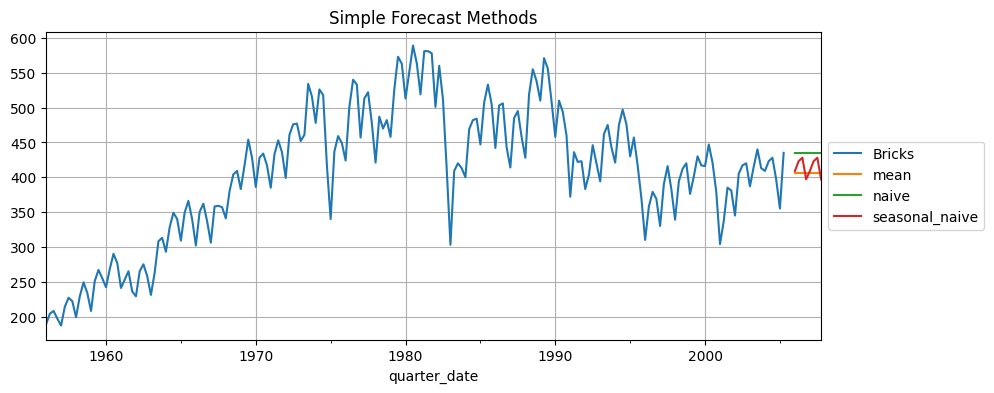

In [12]:
fig, ax = plt.subplots(figsize=(10,4))
df_bricks.plot(x='quarter_date', y='Bricks', ax=ax, grid=2);

for method in forecast.iloc[:, 1:]:
    forecast.plot(x='quarter_date', y=method, grid=2, ax=ax)

ax.set_title("Simple Forecast Methods")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

#### 1.2. Beer Production

In [2]:
df = pd.read_csv('../data/aus_production.csv', index_col=[0])

df = df[['Quarter', 'Beer']].dropna()

df['Quarter'] = pd.PeriodIndex(df['Quarter'].str.replace(' ', '-'), freq='Q')

df['quarter_date'] = pd.to_datetime(df.Quarter.apply(lambda x: f'{x.year}-{x.month}-01'))

df = df[df["quarter_date"] >= "2000-01-01"]

df = df.sort_values(by="quarter_date").reset_index(drop=True)

df.head()

,Quarter,Beer,quarter_date
0,2000Q1,421,2000-03-01
1,2000Q2,402,2000-06-01
2,2000Q3,414,2000-09-01
3,2000Q4,500,2000-12-01
4,2001Q1,451,2001-03-01


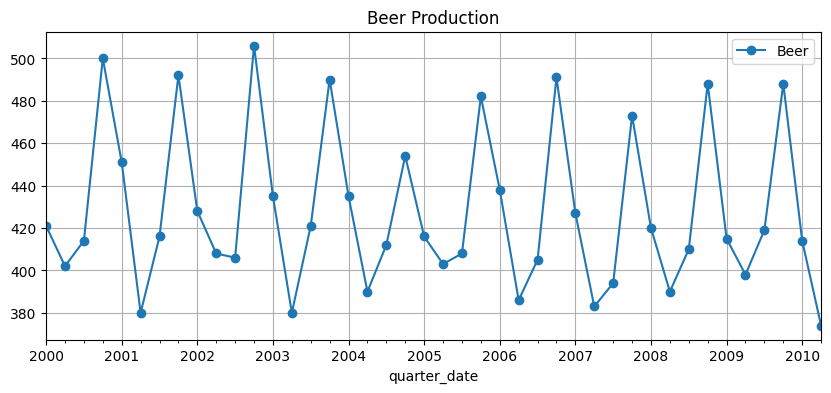

In [3]:
df.plot(
    x="quarter_date", y="Beer", marker="o",
    grid=2, figsize=(10, 4), title="Beer Production"
);

In [4]:
forecast_horizon = 3

In [5]:
mean_forecast = [df["Beer"].mean()] * (forecast_horizon * 4)
naive_forecast = [df["Beer"].iloc[-1]] * (forecast_horizon * 4)
seasonal_naive = df.iloc[-4:]["Beer"].values.tolist() * forecast_horizon

In [6]:
# Eu deveria selecionar o ano de 2009 pois o ano de 2010 não esta completo
# para o seasonal naive!
# Isso fica claro no plot, pois esta deslocado dado que falta 2 Q em 2010.

df.iloc[-6:]

,Quarter,Beer,quarter_date
36,2009Q1,415,2009-03-01
37,2009Q2,398,2009-06-01
38,2009Q3,419,2009-09-01
39,2009Q4,488,2009-12-01
40,2010Q1,414,2010-03-01
41,2010Q2,374,2010-06-01


In [7]:
df_forecast = pd.DataFrame(
    pd.date_range(
        df["quarter_date"].max(),
        df["quarter_date"].max() + pd.offsets.DateOffset(years=3),
        freq="Q-DEC"
    )
)

df_forecast.columns = ["date"]

df_forecast["mean_forecast"] = mean_forecast
df_forecast["naive_forecast"] = naive_forecast
df_forecast["seasonal_naive"] = seasonal_naive

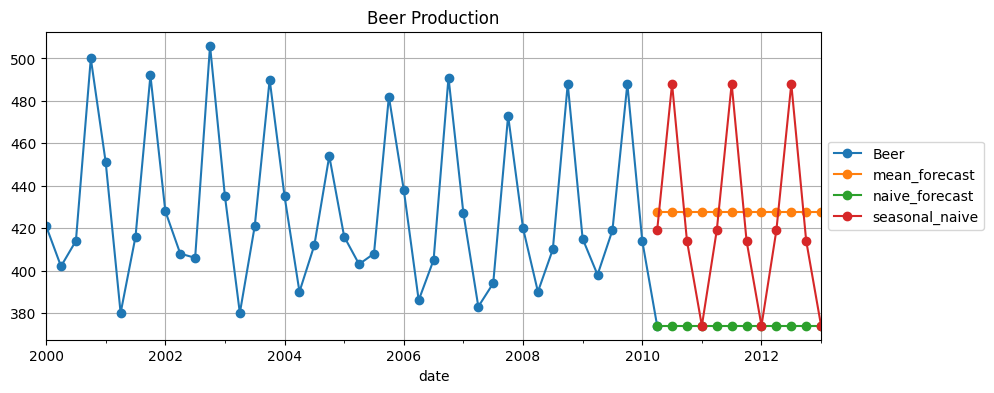

In [8]:
ax = df.plot(
    x="quarter_date", y="Beer", marker="o",
    figsize=(10, 4), title="Beer Production"
)
df_forecast.plot(
    x="date", marker="o", ax=ax, grid=2
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

### 2.0. Valores Fitados e Residuals

Os valores fitados são denotados como $\hat{y_t}$ ou $\hat{y}_{t|t-1}$.


Os valores fitados não são verdadeiros, eles são estimados utilizando o conjunto de dados disponível.


Por exemplo, os valores fitados a partir da média: $\hat{y_t}$ = $\hat{c}$, $\hat{c}$ é a média de todas as observações.


Já os resíduos, é o'que sobra da diferença entre o valor real e o valor estimado, e é denotado por: $\hat{e_t} = y_t - \hat{y_t}$, caso os resíduos estejam transformados, é importante analisar sem a transformação, esses resíduos transformados são chamados de "innovation residuals".


*Assumptions* sobre os resíduos:


1. Não é correlacionado, caso contrário existem informações nos resíduos não capturados pelo estimador.
2. Média 0, caso contrário, as previsões estão com viés.
3. Possui variação constante (homoscedasticity), caso contrário pode afetar o intervalo de previsão.
4. É normalmente distribuído, caso contrário pode afetar o intervalo de previsão.


Para demonstrar isso em python, irei utilizar o primeiro quarter de 2000 como seasonal naive para prever o restante da série.


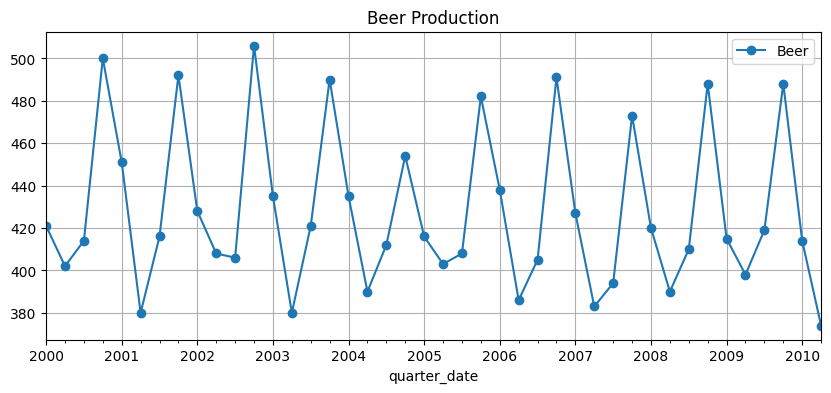

In [56]:
df.plot(
    x="quarter_date", y="Beer", marker="o",
    grid=2, figsize=(10, 4), title="Beer Production"
);

In [68]:
seasonal_naive = df.head(4)["Beer"].values.tolist() * int(df["Quarter"].nunique() / 4 + 1)

# Removendo os 2 ultimos quarters do ultimo ano do dataset pois eles não estão disponíveis.
seasonal_naive = seasonal_naive[:-2]

df["seasonal_naive"] = seasonal_naive

df["naive"] = df["Beer"].shift(1)

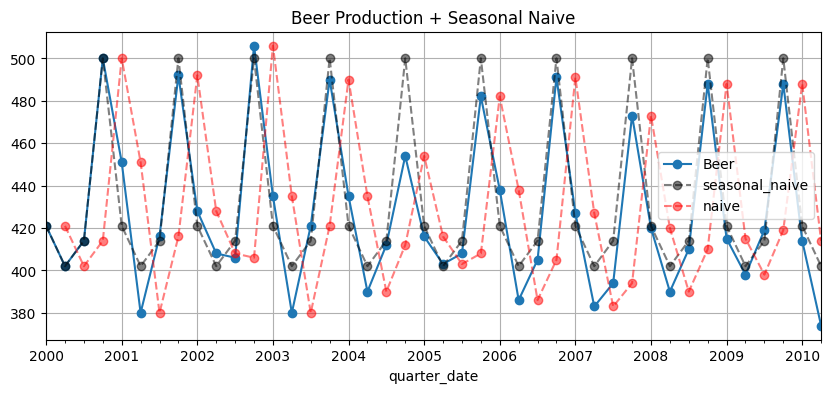

In [73]:
ax = df.plot(
    x="quarter_date", y="Beer", marker="o",
    grid=2, figsize=(10, 4), title="Beer Production + Seasonal Naive"
)
ax = df.plot(
    x="quarter_date", y="seasonal_naive", marker="o",
    color="k", linestyle="--", alpha=0.5, ax=ax
)
df.plot(
    x="quarter_date", y="naive", marker="o",
    grid=2, color="r", linestyle="--", alpha=0.5, ax=ax
);

In [59]:
df["fitted_values"] = df["seasonal_naive"].values
df["residuals"] = (df["Beer"] - df["seasonal_naive"]).values

A média não é zero.

Parece que os resíduos não possuem variação constante visualizando o gráfico e calculando a variância ou o desvio padrão ao longo dos anos eles não são constantes. 

In [60]:
df["residuals"].describe()

count    42.000000
mean     -5.476190
std      13.654693
min     -46.000000
25%     -12.000000
50%      -5.500000
75%       1.750000
max      30.000000
Name: residuals, dtype: float64

In [61]:
df["year"] = df["quarter_date"].dt.year

df[["year", "residuals"]].groupby("year").std()

,residuals
year,
2000,0.000000
2001,21.992423
2002,7.182154
2003,16.317169
2004,25.370587
2005,7.958224
2006,14.545904
2007,14.445299
2008,5.619905


Esperamos no ACF visualizar um padrão estilo white noise.

/tmp/ipykernel_5119/3034256359.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=3)


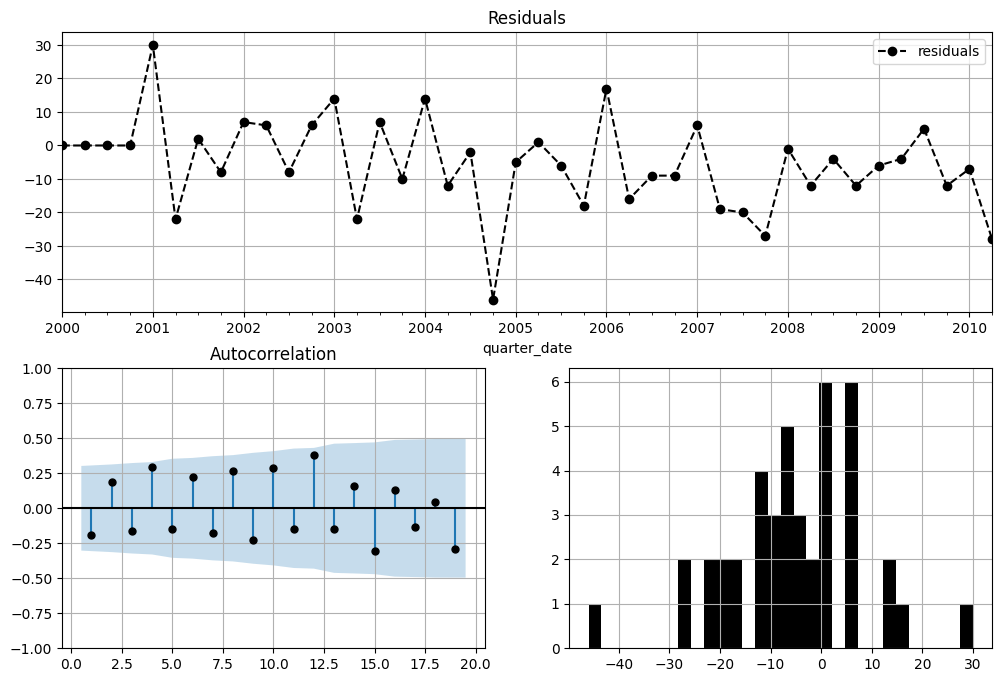

In [62]:
fig, _, = plt.subplots(figsize=(12, 8))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=3)
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1))

df.plot(
    x="quarter_date", y="residuals", marker="o", title="Residuals",
    grid=2, color="k", linestyle="--", ax=ax0
);

plot_acf(df["residuals"], lags=range(1,20), color="k", ax=ax1);

# "Residuals Distribution"
df["residuals"].hist(bins=30, color='k', ax=ax2);

for axi in [ax0, ax1, ax2]: axi.grid(2);

O resíduo tem **média -5**, preciso somar esse -5 em todos os valores fitados para corrigir isso.

"Adjusting for bias is easy: if the residuals have mean m, then simply add m to all forecasts and the bias problem is solved.".

Já para corrigir a autocorrelação, vai ser endereçada no capítulo 10.

In [63]:
df["fitted_adj_values"] = df["fitted_values"] + df["residuals"].mean()

df["residuals"] = (df["Beer"] - df["fitted_adj_values"]).values

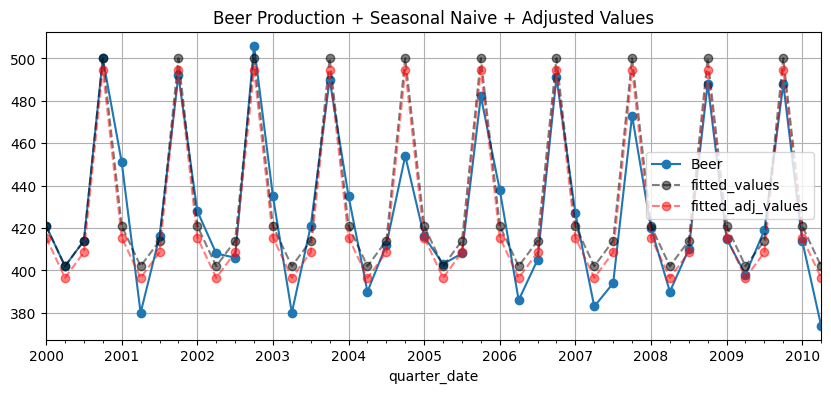

In [64]:
ax = df.plot(
    x="quarter_date", y="Beer", marker="o",
    grid=2, figsize=(10, 4), title="Beer Production + Seasonal Naive + Adjusted Values"
)
ax = df.plot(
    x="quarter_date", y="fitted_values", marker="o",
    grid=2, color="k", linestyle="--", alpha=0.5, ax=ax
);
df.plot(
    x="quarter_date", y="fitted_adj_values", marker="o",
    grid=2, color="r", linestyle="--", alpha=0.5, ax=ax
);


In [65]:
df["residuals"].describe()

count    4.200000e+01
mean     5.413659e-15
std      1.365469e+01
min     -4.052381e+01
25%     -6.523810e+00
50%     -2.380952e-02
75%      7.226190e+00
max      3.547619e+01
Name: residuals, dtype: float64

In [66]:
df[["year", "residuals"]].groupby("year").std()

,residuals
year,
2000,0.000000
2001,21.992423
2002,7.182154
2003,16.317169
2004,25.370587
2005,7.958224
2006,14.545904
2007,14.445299
2008,5.619905


/tmp/ipykernel_5119/3034256359.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=3)


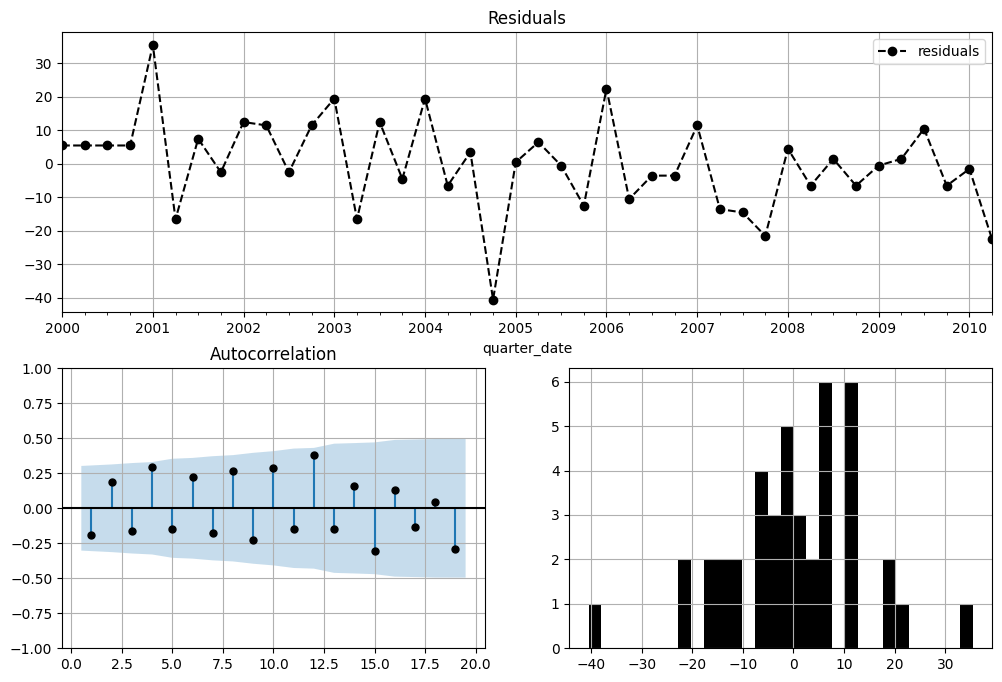

In [67]:
fig, _, = plt.subplots(figsize=(12, 8))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=3)
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1))

df.plot(
    x="quarter_date", y="residuals", marker="o", title="Residuals",
    grid=2, color="k", linestyle="--", ax=ax0
);

plot_acf(df["residuals"], lags=range(1,20), color="k", ax=ax1);

# "Residuals Distribution"
df["residuals"].hist(bins=30, color='k', ax=ax2);

for axi in [ax0, ax1, ax2]: axi.grid(2);

Existe também testes de hipóteses estatísitcas a fim de validar a assumption da autocorrelação, como o test portmanteau, box-pierce e ljung-box.

In [136]:
lj = acorr_ljungbox(df["residuals"], lags=[8], period=4, boxpierce=True, return_df=True)

In [137]:
lj

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,1.619820,0.203117,1.509378,0.219234
2,3.205350,0.201357,2.950769,0.228691
3,4.404537,0.220965,4.013684,0.259990
4,8.732577,0.068143,7.751537,0.101116
5,9.870472,0.078990,8.708403,0.121276
6,12.401645,0.053585,10.779363,0.095440
7,14.072135,0.049913,12.108162,0.097058
8,17.856015,0.022332,15.032070,0.058525
